<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/hbayes_figures2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make figures for hierarchical Bayesian regression models


In [1]:
import graphviz

In [2]:
def create_node(
    dot,
    character,
    subscript="",
    superscript="",
    color="white",
    fill_color="white",
    fontcolor="black",
    is_greek_letter=False,
):
    label, index = "", ""
    if subscript != "" and superscript != "":
        label = f"<SUB>{subscript}</SUB><SUP>{superscript}</SUP>"
        index = f"{subscript}{superscript}"
    elif subscript != "":
        label = f"<SUB>{subscript}</SUB>"
        index = f"{subscript}"
    elif superscript != "":
        label = f"<SUP>{superscript}</SUP>"
        index = f"{superscript}"

    if is_greek_letter:
        dot.node(
            f"{character}{index}",
            f"<&{character};<FONT POINT-SIZE='12'>{label}</FONT>>",
            color=color,
            fontcolor=fontcolor,
        )
    else:
        dot.node(
            f"{character}{index}",
            f"<{character}<FONT POINT-SIZE='10'>{label}</FONT>>",
            style="filled",
            color=color,
            fillcolor=fill_color,
            fontcolor=fontcolor,
        )

In [3]:
def create_subgraph(
    dot, hidden, observable, subscript, superscript, name, label="", color="grey", bgcolor="white", edge_color="black"
):
    dot.edge(f"{hidden}{subscript}{superscript}", f"{observable}{subscript}{superscript}", style="invis")

    with dot.subgraph(name=name) as c:
        c.edge(label, f"{hidden}{subscript}{superscript}", style="invis")
        create_node(c, observable, subscript, superscript=superscript, color=obs_color, fill_color=obs_fill_color)
        c.edge(f"{observable}{subscript}{superscript}", f"{hidden}{subscript}{superscript}", color=edge_color)
        c.edge(f"{hidden}{subscript}{superscript}", f"{observable}{subscript}{superscript}", style="invis")
        c.attr(
            style="rounded",
            color=color,
            bgcolor=bgcolor,
            label=f"<<FONT POINT-SIZE='16'>{subscript.upper()}<SUP>{superscript}</SUP></FONT>>",
            fontcolor=color,
            labeljust="r",
            labelloc="b",
        )

In [4]:
def plot_cluster(dot, subscripts, superscript, subgraph_labels, subgraph_colors, theta_subscript=""):
    for k, (subscript, label, color) in enumerate(zip(subscripts, subgraph_labels, subgraph_colors)):
        if subscript == "N":
            create_node(
                dot, hidden, subscript=subscript, superscript=superscript, color=hid_color, fill_color=hid_fill_color
            )
        else:
            create_node(dot, hidden, subscript=subscript, superscript=superscript, color=hid_color)

        subgraph_name = f"cluster_{superscript}_{k}"
        dot.node(label, label, color="white", fontcolor=color)
        s = superscript if theta_subscript == "" else f"{theta_subscript}{superscript}"
        dot.edge(f"Theta{s}", f"{hidden}{subscript}{superscript}", color=edge_color)
        dot.edge(f"Theta{s}", f"{label}", style="invis")

        create_subgraph(
            dot,
            hidden,
            observable,
            subscript,
            superscript,
            subgraph_name,
            label=label,
            color=color,
            bgcolor="white",
            edge_color=edge_color,
        )

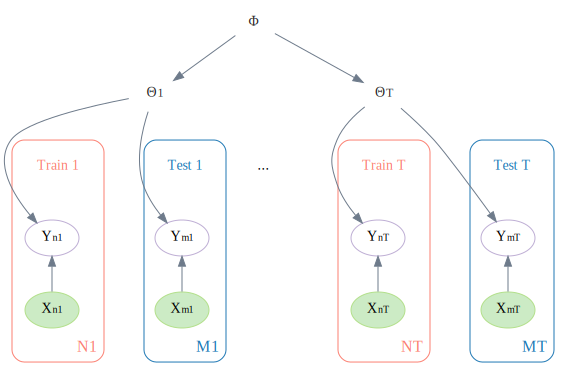

In [5]:
dot = graphviz.Digraph(format="pdf")


superscripts = ["1", "T"]

train_subscript, test_subscript = "n", "m"
subscripts = [train_subscript, test_subscript]

subgraph_labels = ["Train", "Test"]
subgraph_colors = ["/set34/4", "/paired3/2"]

edge_color = "lightsteelblue4"
fontcolor = "grey17"
hid_color, hid_fill_color = "/accent3/2", "lavender"
obs_color, obs_fill_color = "/paired3/3", "/pastel19/3"

param, hidden, observable = "Theta", "Y", "X"

dot.node("phi", "<&Phi;>", color="white", fontcolor=fontcolor)

for i, subscript in enumerate(superscripts):
    create_node(dot, param, subscript, color="white", fontcolor=fontcolor, is_greek_letter=True)
    dot.edge("phi", f"{param}{subscript}", color=edge_color)

for i, superscript in enumerate(superscripts):
    subgraph_labels = [f"Train {superscript}", f"Test {superscript}"]
    plot_cluster(dot, subscripts, superscript, subgraph_labels, subgraph_colors)

    if i == 0:
        dot.node(f"blank{i}", "...", color="white")
        dot.edge(f"Theta{superscript}", f"blank{i}", style="invis")

file_name = "hbayes-multi-task"
dot.render(file_name, view=True)

dot

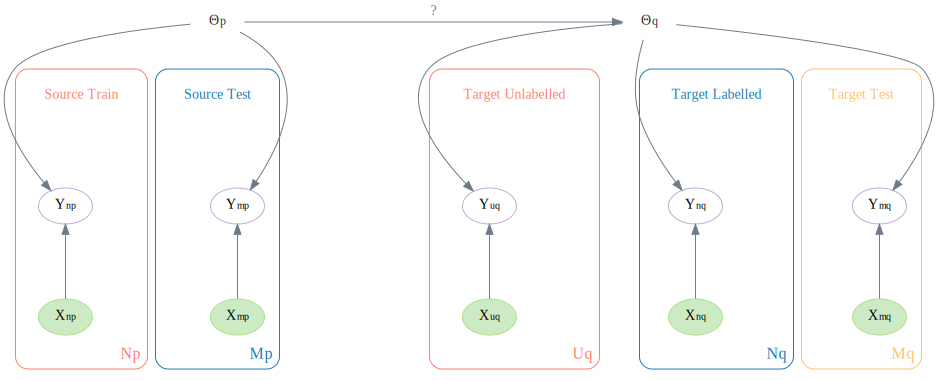

In [7]:
dot = graphviz.Digraph(format="pdf")


source_superscripts = ["p"]
target_superscripts = ["q"]

source_subscripts = ["n", "m"]
target_subscripts = ["n", "m", "u"]

alternative_colors = ["/paired3/2", "/paired9/7", "/set34/4"]

source_labels = ["Source Train", "Source Test"]
target_labels = ["Target Labelled", "Target Test", "Target Unlabelled"]

for i, (sup, labels) in enumerate(zip([source_superscripts, target_superscripts], [source_labels, target_labels])):
    sup = sup[0]
    for label in labels:
        create_node(dot, param, sup, color="white", fontcolor=fontcolor, is_greek_letter=True)
    if i == 0:
        dot.node(f"blank{i}", "", color="white")
        dot.edge(f"Theta{sup}", f"blank{i}", color="white", style="invis")

dot.edge(
    f"{param}{source_superscripts[0]}",
    f"{param}{target_superscripts[0]}",
    label="?",
    color=edge_color,
    fontcolor=edge_color,
    constraint="false",
)
dot.edge(f"{param}{target_superscripts[0]}", f"{param}{source_superscripts[0]}", style="invis", constraint="false")

plot_cluster(
    dot,
    subscripts=source_subscripts,
    superscript=source_superscripts[0],
    subgraph_labels=source_labels,
    subgraph_colors=subgraph_colors,
    theta_subscript="",
)
plot_cluster(
    dot,
    subscripts=target_subscripts,
    superscript=target_superscripts[0],
    subgraph_labels=target_labels,
    subgraph_colors=alternative_colors,
    theta_subscript="",
)

for i, (subscript, labels) in enumerate(
    zip([source_superscripts, target_superscripts], [source_labels, target_labels])
):
    subscript = subscript[0]
    for label in labels[::-1]:
        create_node(dot, param, subscript, color="white", fontcolor=fontcolor, is_greek_letter=True)

file_name = "hbayes-domain-shift"
dot.render(file_name, view=True)

dot

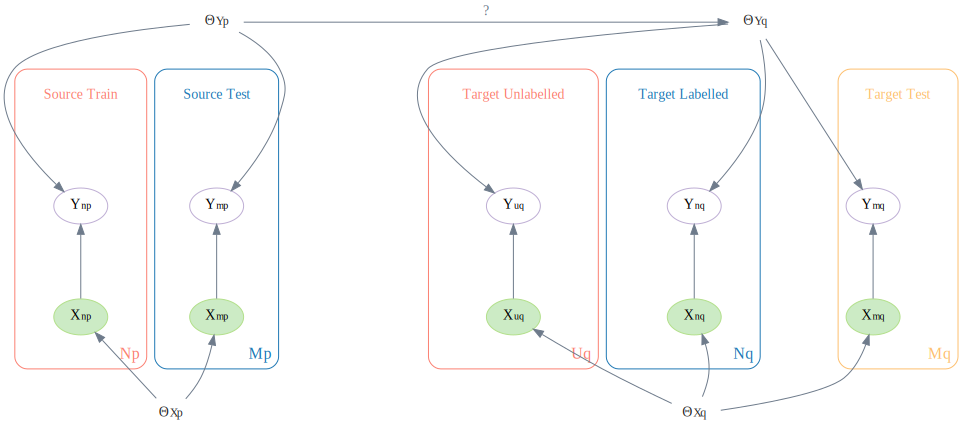

In [8]:
dot = graphviz.Digraph(format="pdf")

source_superscripts = ["p"]
target_superscripts = ["q"]

source_subscripts = ["n", "m"]
target_subscripts = ["n", "m", "u"]

target_labels = ["Target Unlabelled", "Target Labelled", "Target Test"]
alternative_colors = subgraph_colors + ["/paired9/7"]
target_subscripts = ["u", "n", "m"]


for i, (subscript, superscript, labels) in enumerate(
    zip(
        [source_superscripts, target_superscripts],
        [source_superscripts, target_superscripts],
        [source_labels, target_labels],
    )
):
    for label in labels:
        create_node(dot, param, hidden, superscript[0], color="white", fontcolor=fontcolor, is_greek_letter=True)
    if i == 0:
        dot.node(f"blank{i}", "", color="white")
        dot.edge(f"Theta{hidden}{ superscript[0]}", f"blank{i}", style="invis")

dot.edge(
    f"{param}{hidden}{source_superscripts[0]}",
    f"{param}{hidden}{target_superscripts[0]}",
    label="?",
    color=edge_color,
    fontcolor=edge_color,
    constraint="false",
)
dot.edge(
    f"{param}{hidden}{target_superscripts[0]}",
    f"{param}{hidden}{source_superscripts[0]}",
    style="invis",
    constraint="false",
)

plot_cluster(
    dot,
    subscripts=source_subscripts,
    superscript=source_superscripts[0],
    subgraph_labels=source_labels,
    subgraph_colors=subgraph_colors,
    theta_subscript="Y",
)
plot_cluster(
    dot,
    subscripts=target_subscripts,
    superscript=target_superscripts[0],
    subgraph_labels=target_labels,
    subgraph_colors=alternative_colors,
    theta_subscript="Y",
)

for i, (subscript, superscript, labels) in enumerate(
    zip(
        [source_subscripts, target_subscripts],
        [source_superscripts, target_superscripts],
        [source_labels, target_labels],
    )
):
    for label, s in zip(labels, subscript):
        create_node(dot, param, observable, superscript[0], color="white", fontcolor=fontcolor, is_greek_letter=True)
        dot.edge(
            f"Theta{observable}{superscript[0]}",
            f"{observable}{s}{superscript[0]}",
            color=edge_color,
            fontcolor=edge_color,
            constraint="false",
        )
        dot.edge(f"{observable}{s}{superscript[0]}", f"Theta{observable}{superscript[0]}", style="invis")


file_name = "hbayes-domain-shift-xy"
dot.render(file_name, view=True)

dot